# solving job shop scheduling problem with GA

- [la40 (Tailored Version)](http://jobshop.jjvh.nl/instance.php?instance_id=49#:~:text=as%20text%20file.-,Taillard%20specification,-Specification%20according%20to)


https://github.com/Eason0227/Job-shop-scheduling-problem/blob/main/GA%20for%20JSSP.ipynb


In [1]:
import os
from typing import List
import pandas as pd
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# from plotly.offline import iplot

import plotly.figure_factory as ff
import datetime

from algorithms.genetic_algorithm import initial_population
from utils.drawing_tool import create_colors
from utils.paths import JSSP_DATA_PATH
from utils.types import Chromosome

# job数 * machine数 個の int 型要素を持つ遺伝子のためのList型
Chromosome = list[int]

JSSP_DATA_PATH

'/working_dir/notebooks/data/jssp'

# データ読み込み

In [2]:
# la40
with open(os.path.join(JSSP_DATA_PATH, "la40.txt"), "r") as f:
    la40_data: list = [
        line.rstrip("\n").split("\t")
        for line in f.readlines()
    ]


num_machines, num_jobs = la40_data[0]
processing_time_per_job = la40_data[1:16]
machine_sequence_per_job = la40_data[16:31]

processing_time_per_job = pd.DataFrame(processing_time_per_job).astype(int)
machine_sequence_per_job = pd.DataFrame(machine_sequence_per_job).astype(int)

num_machine = processing_time_per_job.shape[0]  # number of machines
num_job = processing_time_per_job.shape[1]  # number of jobs
num_gene = num_machine * num_job  # number of genes in a chromosome

# processing_times
pt = processing_time_per_job.values.tolist()
#　machine_sequences for tasks
ms = machine_sequence_per_job.values.tolist()


In [3]:
# # https://github.com/Eason0227/Job-shop-scheduling-problem/tree/main/JSP%20data
# processing_df= pd.read_csv("data/jssp/Processing_time.csv")
# sequence_df = pd.read_csv("data/jssp/Machine_sequence.csv")

# processing_df = processing_df.drop(["Job"],axis=1)
# sequence_df = sequence_df.drop(["Job"],axis=1)

# num_machine = processing_df.shape[0]  # number of machines
# num_job = processing_df.shape[1]  # number of jobs
# num_gene = num_machine * num_job  # number of genes in a chromosome

# # processing_times
# pt = [list(map(int, processing_df.iloc[i])) for i in range(num_job)]
# #　machine_sequences for tasks
# ms = [list(map(int, sequence_df.iloc[i])) for i in range(num_job)]


In [3]:
pt

[[65, 28, 74, 33, 51, 75, 73, 32, 13, 81, 35, 59, 38, 55, 27],
 [64, 53, 83, 33, 6, 52, 72, 7, 90, 21, 23, 10, 39, 49, 72],
 [73, 82, 23, 62, 88, 21, 65, 70, 53, 81, 93, 77, 61, 28, 78],
 [12, 51, 33, 15, 72, 98, 94, 12, 42, 24, 15, 28, 6, 99, 41],
 [97, 7, 96, 15, 73, 43, 32, 22, 42, 94, 23, 86, 78, 24, 31],
 [72, 88, 93, 13, 44, 66, 63, 14, 67, 17, 85, 35, 68, 5, 49],
 [15, 82, 21, 53, 72, 49, 99, 26, 56, 45, 68, 51, 8, 27, 96],
 [54, 24, 14, 38, 36, 52, 55, 37, 48, 93, 60, 70, 23, 23, 83],
 [12, 69, 26, 23, 28, 82, 33, 45, 64, 15, 9, 73, 59, 37, 62],
 [87, 12, 80, 50, 48, 90, 72, 24, 14, 71, 44, 46, 15, 61, 92],
 [54, 22, 61, 46, 73, 16, 6, 94, 93, 67, 54, 75, 32, 40, 97],
 [92, 36, 22, 9, 47, 77, 79, 36, 30, 98, 79, 7, 55, 6, 30],
 [49, 83, 73, 82, 82, 92, 73, 31, 35, 54, 7, 37, 72, 52, 76],
 [98, 34, 52, 26, 28, 39, 80, 29, 70, 43, 48, 58, 45, 94, 96],
 [70, 17, 90, 67, 14, 23, 21, 18, 43, 84, 26, 36, 93, 84, 42]]

In [4]:
tmp = np.random.permutation(num_gene) % num_job
# pd.Series(tmp).value_counts()
tmp

array([ 6,  9, 13, 11,  7, 10,  6,  6,  2,  9,  0, 13, 11,  7,  3,  4, 14,
        0,  1,  4, 13, 13, 11,  0,  9,  2,  9,  6,  9,  5,  1,  2, 14,  1,
        0, 10,  7, 10, 12,  5,  7,  3,  6,  3,  5,  6,  9,  8,  1,  7,  9,
       11,  3, 13, 12,  8, 14,  3, 10,  8, 10,  1,  6, 11, 13,  9,  5, 10,
        4, 12, 13, 11,  9,  8,  6, 14,  5, 14, 12,  8,  2,  7, 11,  8, 13,
        8, 13,  2,  5,  2, 14, 10,  6,  4,  5,  3,  2, 11,  9, 11,  1,  3,
       14,  1,  4,  7,  7, 14, 12,  0,  6, 10, 13,  4,  5,  9,  9, 14, 14,
        3,  9,  7,  3,  4,  0, 11,  0, 10,  6,  6,  5, 12,  0, 13, 10, 11,
        1, 12,  3,  0, 12, 10, 11,  7,  5,  3,  9,  3,  2,  4, 10, 12,  1,
        4, 13, 14, 12,  6,  4,  8,  4,  1,  7,  0,  3,  2, 11,  7,  1, 14,
        8, 12,  8,  3,  0,  2, 12, 13,  1, 11,  2, 10,  0,  6,  2, 14,  8,
        4, 12, 10, 10,  1,  6, 12,  5, 14,  1,  5,  4, 13,  5,  2,  1,  2,
        0,  8,  7,  8, 11,  8,  7, 13,  0,  3,  4, 12,  7,  0,  5,  5, 14,
        8,  2,  9,  4])

In [5]:
def crossover(population_list: list, crossover_rate: float):
    """
    2点交叉を行う
    """
    parent_list: list = population_list.copy() # preserve the original parent chromosomes
    offspring_list: list = population_list.copy()

    # 組み合わせを生成して、交配に使用する親染色体のセットを選択します
    parent_sequence = list(np.random.permutation(population_size))
    for i in range(0, population_size, 2):
        crossover_prob=np.random.rand()
        if crossover_prob <= crossover_rate:
            parent_1 = population_list[ parent_sequence[i] ][:]
            parent_2 = population_list[ parent_sequence[i + 1] ][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            # 2つの異なる交点を生成し、小さいものから大きいものに並べ替えます。
            crossover_point = list( np.random.choice(num_gene, 2, replace=False) )
            crossover_point.sort()

            # parent_2 の中央にある遺伝子が parent_1 の中央に移動され、child1 が生成されます。
            child_1[crossover_point[0]:crossover_point[1]] = parent_2[crossover_point[0]:crossover_point[1]]
            # parent_1 の遺伝子を parent_2 に移し、child2 を作る。
            child_2[crossover_point[0]:crossover_point[1]] = parent_1[crossover_point[0]:crossover_point[1]]

            offspring_list[parent_sequence[i]] = child_1[:]
            offspring_list[parent_sequence[i + 1]] = child_2[:]
    return parent_list, offspring_list


# 染色体内の各アーティファクトの発生数は 10 ですが、上記の交配作用により、一部の染色体におけるアーティファクトの発生数は 10 未満または 10 を超え、
# 実行不可能なスケジューリング ソリューションが形成されるため、ここで次のことを行う必要があります。
# 実行不可能な染色体が修復作用を受けて実行可能なスケジュールになることに焦点を当てる
def repairmet(offspring_list):
    stop = True

    # 各ジョブの発生回数が正しい数になるまで修復を続ける。
    while stop:
        
        for i in range(population_size):
            unique_elements, counts = np.unique( offspring_list[i] , return_counts=True)  # 各ジョブの発生回数
            if sum(counts!= num_machine) != 0:  # 複数の仕事と欠落した仕事 
                less_job = np.argmin(counts)  # 出現回数が不足している job
                large_job = np.argmax(counts)  # 出現回数が超過している job
                offspring_array = np.array( offspring_list[i] )
                offspring_job_large_index = np.where( offspring_array == large_job)[0][0] # より多く出現している job の最初の位置
                offspring_list[i][offspring_job_large_index] = less_job # 出現回数の超過している job_idを、回数の少ない job_id に置換
        counts_sum = 0

        # すべての染色体に異常がないか調べる
        for j in range(population_size):
            unique_elements, counts = np.unique( offspring_list[j] , return_counts=True)
            if sum(counts != num_machine) != 0 :
                counts_sum += 1
        if counts_sum == 0:
            stop = False
    return offspring_list


def mutation(offspring_list, mutation_rate, num_mutation_jobs):
    for i in range(population_size):
        mutation_prob=np.random.rand()
        if  mutation_prob <= mutation_rate:
            # 変異の場所を選ぶ
            mutation_position = list(np.random.choice(num_gene, num_mutation_jobs, replace=False))
            muta_list = []
            for j in mutation_position:
                muta_list.append(offspring_list[i][j]) # 変異させる遺伝子のリスト
            muta_list.append(muta_list[0]) # 先頭の遺伝子を末尾に加える
            muta_list.pop(0) # 先頭の遺伝子を削除
            count = 0
            for k in mutation_position:
                # 変異した遺伝子で、元の遺伝子を置き換える
                offspring_list[i][k] = muta_list[count]
                count += 1
    return offspring_list


def _calc_time4job(
    target_chromosome: Chromosome, num_job: int, num_machine: int
) -> dict[int, int]:
    """
    対象個体の遺伝子をスケジュールにしたときに、実際にどのくらい時間がかかるかを計算する

    len(target_chromosome) => num_job * num_machine
    """
    j_keys: list[int] = [j for j in range(num_job)]
    # job の key 番目のタスクが処理された回数をカウントする
    key_count: dict[int, int] = {key: 0 for key in j_keys}

    # 各 job にかかる時間を格納するための辞書
    time4job: dict[int, int] = {key: 0 for key in j_keys}

    m_keys: list[int] = [j + 1 for j in range(num_machine)]
    time4machine: dict[int, int] = {key: 0 for key in m_keys}

    # 1個体の染色体を一つずつ処理
    for i in target_chromosome:
        # 次に処理すべきタスクのID
        task_no: int = key_count[i]

        # 処理時間
        gen_t: int = int(pt[i][task_no])
        # ジョブにおける、機械の処理順
        gen_m: int = int(ms[i][task_no])

        # i番目のジョブ内のタスク実行にかかった時間合計
        time4job[i] = time4job[i] + gen_t
        # gen_m 番目の機械における処理時間合計
        time4machine[gen_m] = time4machine[gen_m] + gen_t

        # ジョブ毎にかかった時間、もしくは機械毎にかかった時間のうち、小さい方を、大きい方の値で上書きする
        if time4machine[gen_m] < time4job[i]:
            time4machine[gen_m] = time4job[i]
        elif time4machine[gen_m] > time4job[i]:
            time4job[i] = time4machine[gen_m]
        
        key_count[i] = key_count[i] + 1
    return time4job


def fitness_caculate(total_chromosome: list[Chromosome]):
    """
    適応度の計算を行う

    Partameters
    ------
    total_chromosome: list[Chromosome]
        parent and offspring

    Returns
    ------
    chrom_fit: list[int]
        各染色体から計算された makespan の配列 (小さい方が良い)

    chrom_fitness: list[float]
        各染色体から計算された makespan の逆数の配列 (大きい方が良い)

    total_fitness: int
        各染色体から計算された makespan の逆数の合計 (大きい方が良い)
    """
    chrom_fitness, chrom_fit = [], []
    total_fitness: int = 0
    for individual_id in range(population_size * 2):  # 親と子の2世代分ループするので 2倍
        time4job: dict[int, int] = _calc_time4job(total_chromosome[individual_id], num_job, num_machine)

        # 最も時間がかかる仕事は makespan である。
        makespan = max(time4job.values())
        # 各染色体について計算された適応値は、その後ルーレットホイール法を使用する際の完了時間を最小にするために、
        # 逆順に記録されなければならない。
        chrom_fitness.append(1 / makespan)

        # 各染色体の元完了時間の合計を計算する。
        chrom_fit.append(makespan)
        total_fitness = total_fitness + chrom_fitness[individual_id]

    return chrom_fit, chrom_fitness, total_fitness


def selection(chrom_fitness, total_fitness, total_chromosome, population_list):
    """
    selection(roulette wheel approach)
    """
    fitness_prob, fitness_cumulate_prob = [], []

    for i in range(population_size*2):
        # 各染色体のフィットネスを全染色体に占める割合で計算する。
        fitness_prob.append(chrom_fitness[i] / total_fitness)
    for i in range(population_size * 2):
        cumulative = 0
        # 各染色体のフィットネス発生率を計算する。
        for j in range(0, i + 1):
            cumulative = cumulative + fitness_prob[j]
        fitness_cumulate_prob.append(cumulative) 

    # 母集団の大きさを持つ乱数のリストを生成する。
    selection_rand = [np.random.rand() for i in range(population_size)]

    # 新しい population を選択する
    for i in range(population_size):
        # 最初の組合せが選択されたら、最初の染色体を加える
        if selection_rand[i] <= fitness_cumulate_prob[0]:
            population_list[i] = total_chromosome[0].copy()
        else:
            for j in range(0, population_size * 2 - 1): 
                if selection_rand[i] > fitness_cumulate_prob[j] and selection_rand[i] <= fitness_cumulate_prob[j + 1]:
                    population_list[i] = total_chromosome[j + 1].copy()
                    break
    return population_list


def comparsion(chrom_fit, total_chromosome):
    Tbest_current = 99999999999
    for i in range(population_size*2):
        # 最小 fitness の染色体を選択
        if chrom_fit[i] < Tbest_current:
            Tbest_current = chrom_fit[i] 
            sequence_current = total_chromosome[i].copy()
    return Tbest_current, sequence_current

In [6]:
# parameter
population_size = 150
num_iteration = 9999
crossover_rate = 0.95
mutation_rate = 0.05
mutation_selection_rate = 0.1
num_mutation_jobs = round(num_gene * mutation_selection_rate)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2016
execution_time: 600.0441372394562
optimal solution [3, 12, 0, 8, 12, 8, 0, 0, 11, 4, 5, 7, 12, 9, 6, 13, 0, 9, 3, 6, 7, 8, 3, 5, 10, 7, 8, 8, 8, 3, 7, 2, 3, 7, 3, 11, 11, 2, 1, 1, 7, 13, 10, 4, 7, 13, 14, 8, 2, 10, 13, 9, 13, 4, 5, 4, 10, 7, 4, 1, 13, 13, 13, 11, 5, 4, 14, 6, 12, 4, 10, 0, 7, 8, 2, 14, 9, 9, 8, 0, 6, 4, 14, 13, 1, 4, 0, 9, 8, 1, 7, 8, 12, 14, 6, 2, 4, 12, 5, 2, 9, 3, 4, 0, 11, 7, 8, 6, 2, 13, 1, 6, 5, 9, 14, 0, 1, 2, 14, 11, 0, 7, 3, 10, 1, 5, 14, 5, 13, 11, 2, 3, 4, 0, 6, 5, 10, 14, 12, 9, 0, 3, 9, 14, 2, 6, 12, 11, 8, 6, 14, 3, 12, 3, 13, 7, 11, 7, 2, 1, 10, 14, 9, 6, 4, 12, 11, 3, 4, 9, 2, 5, 11, 3, 9, 4, 8, 14, 1, 1, 12, 2, 10, 0, 10, 2, 11, 6, 10, 3, 12, 6, 9, 13, 14, 5, 2, 1, 9, 6, 1, 0, 0, 13, 11, 6, 5, 8, 10, 10, 5, 12, 13, 12, 11, 5, 1, 5, 14, 10, 11, 12, 1, 10, 7]
optimal makespan: 1661


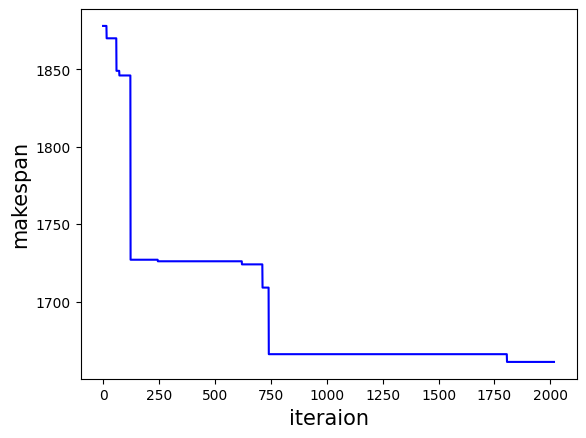

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2029
execution_time: 600.2537569999695
optimal solution [7, 8, 3, 2, 9, 0, 4, 10, 10, 3, 1, 6, 14, 6, 6, 4, 2, 12, 7, 11, 1, 12, 7, 2, 11, 10, 7, 8, 4, 6, 5, 11, 0, 11, 8, 14, 2, 10, 4, 9, 7, 6, 0, 0, 7, 10, 13, 8, 1, 1, 11, 9, 13, 4, 3, 8, 0, 14, 14, 9, 10, 7, 4, 2, 12, 13, 3, 6, 5, 13, 0, 1, 7, 11, 5, 5, 7, 6, 2, 13, 2, 9, 5, 14, 0, 6, 0, 11, 13, 14, 1, 4, 3, 4, 1, 4, 13, 7, 14, 0, 8, 9, 3, 11, 1, 9, 13, 11, 6, 3, 3, 8, 7, 12, 14, 8, 3, 12, 2, 5, 2, 10, 1, 13, 0, 3, 7, 13, 11, 5, 7, 5, 13, 2, 10, 14, 4, 3, 3, 8, 14, 0, 1, 6, 9, 13, 8, 9, 13, 11, 5, 4, 11, 0, 10, 5, 3, 11, 5, 14, 12, 4, 1, 12, 9, 2, 14, 1, 14, 8, 6, 9, 1, 13, 13, 10, 12, 10, 4, 5, 2, 8, 11, 12, 8, 12, 8, 7, 11, 0, 5, 2, 12, 9, 6, 2, 0, 10, 14, 6, 4, 12, 0, 5, 10, 9, 10, 9, 6, 8, 3, 2, 12, 4, 12, 1, 14, 1, 10, 12, 6, 3, 5, 9, 7]
optimal makespan: 1624


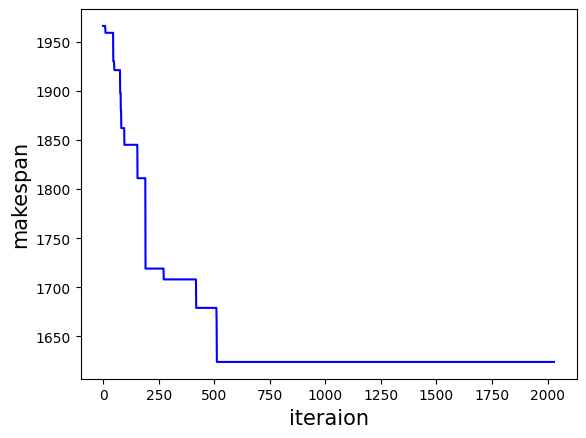

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2038
execution_time: 600.113205909729
optimal solution [11, 8, 11, 3, 7, 3, 9, 7, 7, 5, 9, 7, 3, 7, 14, 7, 3, 0, 8, 8, 5, 2, 2, 6, 0, 2, 14, 9, 4, 14, 13, 3, 4, 8, 1, 9, 7, 13, 11, 5, 5, 2, 1, 2, 13, 7, 13, 8, 2, 4, 10, 3, 11, 12, 4, 12, 3, 13, 2, 11, 10, 2, 4, 4, 0, 6, 3, 5, 11, 2, 9, 14, 0, 13, 6, 12, 12, 11, 10, 3, 11, 13, 9, 1, 0, 4, 11, 7, 3, 6, 8, 12, 13, 14, 6, 8, 8, 5, 0, 14, 5, 6, 1, 8, 2, 9, 1, 11, 12, 6, 6, 2, 1, 14, 8, 3, 12, 7, 9, 13, 10, 6, 13, 10, 1, 9, 5, 4, 1, 5, 8, 4, 13, 8, 5, 4, 12, 14, 8, 5, 0, 12, 3, 4, 10, 2, 9, 13, 6, 14, 10, 0, 10, 6, 0, 11, 11, 4, 10, 14, 7, 1, 13, 1, 10, 3, 0, 2, 5, 0, 12, 1, 0, 12, 6, 12, 6, 9, 2, 9, 3, 10, 2, 1, 11, 0, 5, 8, 13, 14, 1, 4, 5, 8, 6, 14, 9, 12, 7, 10, 3, 9, 14, 13, 4, 12, 11, 4, 10, 7, 10, 1, 12, 7, 9, 5, 0, 11, 0, 1, 6, 10, 14, 7, 14]
optimal makespan: 1628


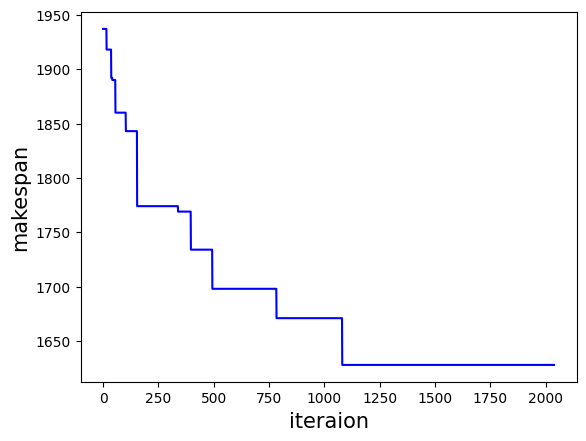

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2039
execution_time: 600.0899815559387
optimal solution [10, 7, 0, 12, 4, 3, 5, 1, 3, 8, 10, 9, 4, 8, 2, 5, 8, 2, 4, 3, 5, 3, 10, 8, 10, 5, 3, 11, 11, 11, 9, 7, 11, 1, 1, 1, 2, 11, 13, 8, 10, 2, 14, 5, 1, 14, 6, 4, 11, 7, 13, 4, 9, 9, 4, 13, 3, 13, 7, 12, 11, 2, 14, 7, 14, 1, 6, 0, 3, 11, 2, 6, 4, 8, 1, 10, 14, 2, 13, 11, 7, 8, 9, 0, 2, 6, 13, 2, 14, 13, 7, 2, 4, 0, 4, 3, 1, 11, 12, 1, 9, 12, 10, 3, 4, 13, 1, 5, 4, 14, 0, 5, 7, 11, 14, 13, 8, 0, 6, 0, 6, 6, 0, 13, 5, 12, 4, 1, 14, 9, 6, 10, 8, 14, 13, 12, 0, 10, 8, 5, 6, 7, 2, 9, 6, 7, 2, 5, 5, 14, 14, 9, 13, 12, 12, 3, 5, 10, 1, 9, 6, 6, 1, 5, 14, 4, 12, 6, 8, 9, 9, 11, 11, 9, 14, 7, 10, 10, 12, 7, 4, 3, 6, 0, 4, 8, 8, 2, 0, 12, 13, 13, 2, 0, 3, 1, 11, 6, 12, 0, 10, 5, 0, 12, 8, 7, 5, 3, 14, 3, 11, 10, 12, 1, 2, 13, 8, 3, 12, 9, 10, 7, 0, 7, 9]
optimal makespan: 1675


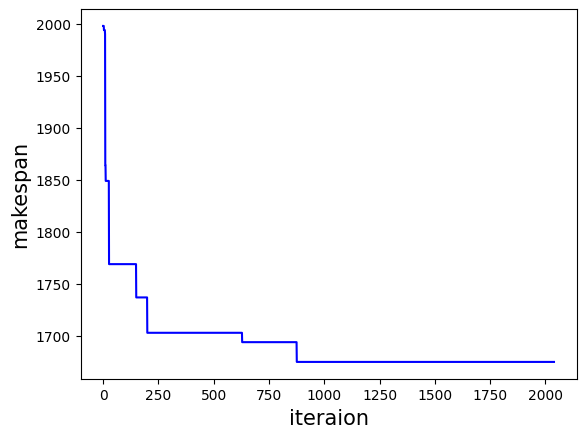

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2034
execution_time: 600.213390827179
optimal solution [5, 12, 6, 7, 0, 4, 6, 4, 4, 5, 2, 10, 7, 5, 3, 7, 3, 0, 4, 4, 1, 8, 5, 10, 14, 8, 4, 2, 9, 10, 9, 3, 1, 7, 2, 8, 2, 9, 4, 6, 5, 3, 13, 13, 7, 1, 12, 13, 8, 0, 2, 8, 1, 7, 13, 8, 2, 3, 12, 11, 5, 1, 2, 3, 13, 13, 12, 8, 8, 4, 14, 9, 1, 11, 2, 10, 7, 13, 10, 3, 7, 1, 12, 2, 6, 5, 9, 14, 6, 2, 0, 14, 1, 4, 8, 9, 13, 14, 3, 13, 14, 5, 1, 11, 0, 10, 6, 10, 14, 11, 0, 14, 14, 0, 12, 7, 7, 6, 4, 10, 3, 9, 8, 10, 6, 13, 4, 0, 7, 5, 13, 0, 14, 9, 13, 12, 11, 10, 7, 11, 4, 9, 0, 5, 12, 0, 3, 8, 2, 3, 9, 12, 6, 13, 5, 10, 14, 11, 11, 2, 13, 11, 4, 7, 6, 10, 8, 6, 12, 11, 1, 10, 12, 9, 14, 6, 0, 9, 3, 12, 8, 14, 10, 9, 4, 11, 12, 0, 3, 11, 7, 13, 14, 1, 5, 3, 2, 8, 6, 10, 5, 5, 1, 9, 6, 1, 7, 11, 0, 5, 2, 3, 8, 9, 2, 4, 12, 12, 11, 6, 0, 1, 1, 14, 11]
optimal makespan: 1683


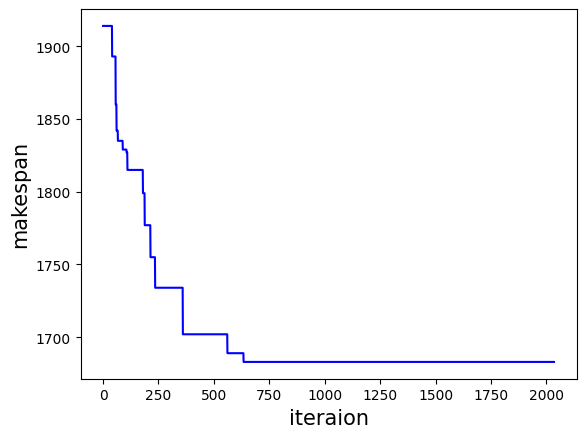

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2034
execution_time: 600.0117015838623
optimal solution [14, 6, 14, 0, 1, 0, 11, 0, 6, 6, 4, 2, 7, 3, 14, 3, 4, 2, 8, 14, 12, 10, 2, 7, 12, 10, 4, 4, 11, 4, 1, 5, 14, 11, 0, 8, 12, 6, 4, 2, 8, 13, 1, 12, 9, 11, 5, 7, 7, 9, 12, 4, 10, 13, 13, 13, 4, 3, 8, 5, 14, 8, 3, 2, 9, 7, 9, 5, 11, 6, 8, 6, 3, 9, 2, 2, 9, 8, 14, 5, 2, 0, 6, 8, 13, 13, 5, 3, 7, 14, 7, 4, 11, 2, 4, 11, 7, 8, 10, 8, 5, 14, 11, 10, 0, 10, 9, 8, 11, 2, 2, 4, 3, 6, 14, 12, 7, 10, 1, 5, 9, 0, 7, 6, 10, 13, 12, 0, 14, 4, 13, 5, 2, 5, 10, 6, 1, 3, 1, 3, 12, 13, 13, 0, 3, 4, 7, 8, 0, 2, 12, 1, 11, 0, 10, 12, 14, 11, 11, 9, 1, 13, 5, 1, 12, 14, 12, 9, 9, 1, 5, 9, 13, 2, 11, 4, 1, 2, 11, 7, 5, 9, 0, 10, 7, 1, 3, 6, 3, 3, 12, 1, 6, 4, 3, 0, 6, 0, 11, 1, 13, 14, 6, 10, 10, 7, 8, 3, 10, 13, 9, 12, 8, 0, 14, 8, 7, 1, 10, 6, 13, 12, 5, 9, 5]
optimal makespan: 1669


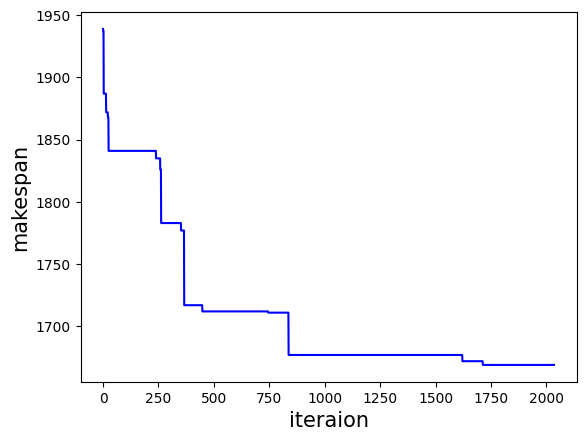

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2022
execution_time: 600.1512656211853
optimal solution [6, 1, 9, 5, 8, 6, 5, 8, 6, 7, 8, 12, 4, 1, 1, 1, 7, 9, 2, 13, 13, 3, 13, 7, 3, 6, 1, 2, 13, 4, 11, 10, 14, 12, 4, 4, 3, 13, 8, 11, 6, 7, 4, 8, 2, 7, 1, 8, 13, 14, 3, 7, 14, 3, 8, 2, 14, 7, 2, 4, 11, 4, 13, 12, 11, 8, 2, 7, 1, 0, 11, 4, 8, 0, 13, 0, 7, 13, 9, 11, 10, 11, 13, 8, 2, 14, 5, 14, 11, 9, 6, 14, 7, 8, 0, 12, 4, 5, 14, 11, 8, 3, 13, 5, 9, 7, 13, 12, 3, 1, 14, 3, 2, 2, 8, 3, 1, 4, 0, 12, 6, 9, 14, 9, 0, 11, 5, 10, 6, 6, 3, 4, 6, 7, 12, 6, 9, 11, 0, 10, 2, 3, 2, 13, 10, 10, 8, 5, 10, 4, 12, 14, 10, 0, 2, 11, 6, 14, 4, 2, 6, 9, 7, 1, 7, 3, 9, 9, 0, 10, 1, 3, 5, 12, 12, 11, 5, 1, 9, 10, 0, 2, 5, 12, 0, 7, 13, 5, 10, 13, 4, 3, 1, 0, 6, 12, 0, 5, 14, 9, 1, 12, 0, 5, 8, 5, 10, 3, 12, 10, 10, 11, 10, 0, 9, 1, 14, 6, 5, 14, 4, 2, 9, 12, 11]
optimal makespan: 1658


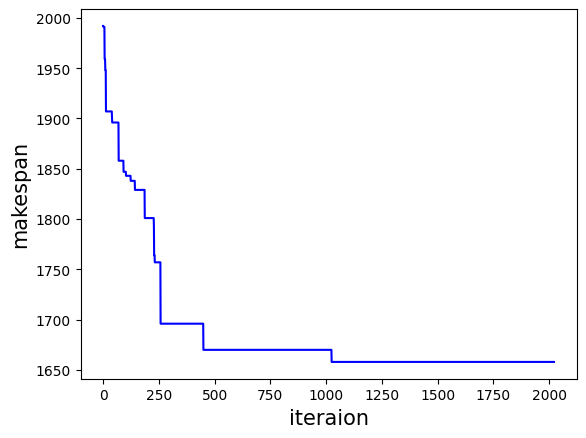

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2064
execution_time: 600.0914943218231
optimal solution [9, 4, 0, 4, 7, 12, 0, 7, 9, 12, 11, 9, 0, 7, 11, 0, 11, 5, 1, 7, 12, 10, 13, 3, 7, 5, 6, 4, 7, 4, 10, 1, 2, 4, 2, 11, 8, 6, 4, 2, 2, 13, 1, 14, 0, 5, 10, 3, 3, 13, 8, 8, 5, 7, 8, 10, 10, 10, 4, 3, 8, 3, 8, 6, 7, 8, 14, 3, 14, 2, 7, 11, 14, 5, 2, 11, 4, 13, 4, 9, 2, 5, 14, 14, 7, 1, 10, 4, 11, 10, 3, 3, 1, 14, 13, 4, 2, 7, 0, 3, 12, 14, 11, 8, 6, 13, 9, 4, 8, 13, 13, 7, 1, 13, 9, 8, 14, 14, 5, 10, 12, 5, 0, 9, 11, 12, 4, 14, 6, 10, 11, 2, 13, 0, 1, 8, 3, 6, 13, 6, 10, 0, 5, 14, 12, 7, 0, 12, 2, 2, 8, 3, 9, 1, 12, 1, 6, 5, 6, 5, 0, 13, 13, 3, 10, 11, 2, 6, 8, 0, 11, 11, 6, 5, 5, 14, 10, 3, 6, 1, 2, 13, 3, 7, 12, 11, 8, 0, 6, 12, 11, 8, 9, 4, 9, 1, 10, 5, 9, 12, 14, 7, 5, 13, 1, 3, 4, 1, 9, 9, 1, 9, 12, 12, 6, 12, 0, 0, 1, 9, 6, 14, 2, 10, 2]
optimal makespan: 1651


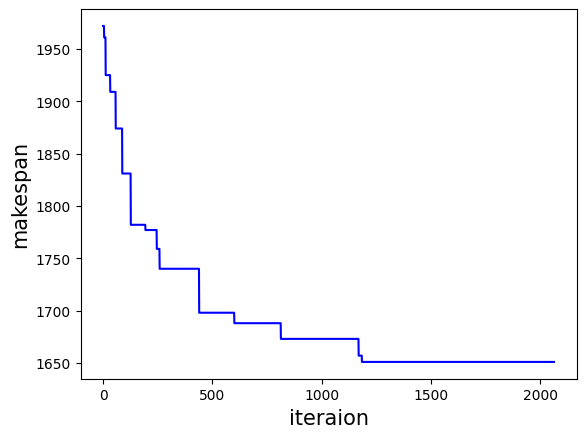

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2005
execution_time: 600.1679525375366
optimal solution [7, 3, 7, 1, 3, 6, 6, 5, 1, 2, 6, 1, 4, 8, 4, 11, 0, 9, 14, 11, 3, 7, 2, 11, 13, 9, 12, 0, 13, 6, 11, 3, 8, 1, 5, 5, 2, 4, 12, 9, 0, 8, 12, 8, 6, 8, 14, 11, 14, 13, 7, 9, 7, 14, 12, 4, 2, 13, 8, 0, 10, 0, 4, 8, 7, 10, 4, 2, 14, 11, 13, 2, 3, 10, 10, 13, 9, 3, 14, 2, 10, 1, 13, 7, 11, 7, 9, 2, 3, 2, 6, 4, 2, 7, 11, 4, 13, 12, 1, 8, 11, 5, 2, 14, 10, 0, 6, 5, 11, 8, 14, 9, 4, 4, 10, 9, 0, 4, 11, 1, 14, 6, 8, 7, 5, 13, 9, 14, 6, 10, 14, 0, 1, 7, 0, 2, 8, 13, 1, 0, 7, 3, 9, 5, 9, 12, 4, 0, 3, 5, 1, 11, 12, 13, 12, 14, 2, 9, 3, 5, 8, 5, 12, 13, 9, 10, 10, 0, 2, 14, 4, 9, 13, 3, 1, 5, 8, 11, 5, 12, 4, 7, 6, 14, 1, 6, 1, 3, 9, 10, 13, 0, 6, 12, 8, 2, 6, 3, 12, 10, 10, 5, 5, 8, 7, 1, 12, 0, 10, 5, 3, 6, 10, 12, 13, 11, 11, 12, 7, 3, 0, 4, 14, 1, 6]
optimal makespan: 1656


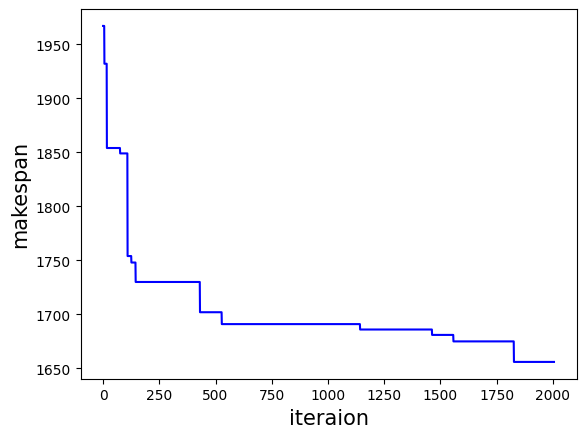

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 2101
execution_time: 600.2733571529388
optimal solution [0, 6, 11, 0, 13, 2, 3, 6, 11, 11, 11, 3, 4, 0, 12, 4, 14, 14, 3, 14, 7, 5, 10, 2, 2, 11, 8, 8, 4, 7, 3, 7, 4, 5, 7, 7, 0, 1, 1, 1, 0, 8, 2, 8, 12, 6, 2, 3, 9, 13, 14, 8, 11, 3, 7, 14, 14, 6, 6, 13, 2, 3, 8, 12, 1, 9, 2, 2, 13, 3, 1, 14, 10, 7, 4, 13, 14, 6, 0, 6, 4, 11, 2, 11, 6, 9, 4, 7, 13, 12, 4, 13, 0, 1, 10, 1, 9, 10, 10, 14, 3, 1, 0, 7, 11, 13, 6, 13, 8, 12, 7, 9, 2, 13, 4, 5, 6, 5, 0, 13, 14, 5, 9, 1, 12, 10, 11, 10, 3, 13, 3, 3, 2, 12, 1, 8, 9, 13, 4, 3, 8, 4, 5, 12, 10, 0, 1, 6, 10, 11, 8, 9, 7, 9, 12, 14, 2, 7, 5, 0, 5, 8, 9, 2, 8, 12, 3, 1, 11, 10, 13, 4, 14, 14, 5, 5, 9, 12, 5, 5, 4, 9, 8, 7, 7, 0, 12, 14, 6, 9, 2, 14, 12, 5, 1, 8, 10, 10, 9, 11, 0, 13, 10, 12, 6, 1, 11, 2, 3, 0, 1, 4, 6, 10, 4, 8, 9, 0, 5, 7, 10, 12, 11, 6, 5]
optimal makespan: 1629


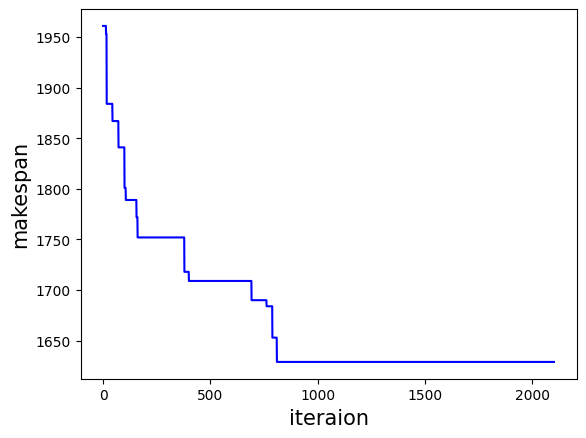

In [26]:
def run_ga(population_list: list[Chromosome]) -> None:
    Tbest: int = 999999999999999
    makespan_record: list[int]= []
    best_gene_history: list[Chromosome] = []
    start_time = time.time()

    # Genetic_Algorithm 
    for iter in tqdm(range(num_iteration)):
        # generate offspring by crossover
        parent_list, offspring_list = crossover(population_list=population_list, crossover_rate=crossover_rate)
    
        # offspring repairment
        offspring_list = repairmet(offspring_list)
    
        # offspring mutation
        offspring_list = mutation(offspring_list,mutation_rate = mutation_rate, num_mutation_jobs = num_mutation_jobs)
    
        # all chromosome: parent and offspring
        total_chromosome = parent_list.copy() + offspring_list.copy()
    
        # calculate fitness for each chromosome
        # chrom_fit, chrom_fitness, total_fitness, = fitness_caculate(total_chromosome)
        chrom_fit, chrom_fitness, total_fitness = fitness_caculate(total_chromosome)
    
        # select the new population
        population_list = selection(chrom_fitness, total_fitness, total_chromosome, population_list)
    
        # comparision 
        Tbest_current, sequence_current = comparsion(chrom_fit, total_chromosome)
        # 現在の世代の集団で最も優れた染色体を、反復プロセスで最も優れた染色体と比較します。
        if Tbest_current <= Tbest:
            Tbest = Tbest_current
            sequence_best = sequence_current.copy()
            best_gene_history.append(sequence_best)
    
        makespan_record.append(Tbest)
    
        # 10 分経過したら終了
        lapse_time = time.time() - start_time
        if lapse_time >= 600.0:
            print("Executed iterrations:", iter)
            break
    
    end_time = time.time()
    
    """----------result----------"""
    print("execution_time:", lapse_time)
    print("optimal solution", sequence_best)
    print("optimal makespan:", Tbest)
    
    
    plt.plot([i for i in range(len(makespan_record))], makespan_record, "b")
    plt.ylabel("makespan", fontsize=15)
    plt.xlabel("iteraion", fontsize=15)
    plt.show()

    best_makespans.append(Tbest)
    exec_time_records.append(lapse_time)

best_makespans: list[int] = []
exec_time_records: list[int] = []
for i in tqdm(range(0, 10)):
    # generate initial population
    population_list: Chromosome = initial_population(
        num_gene=num_gene, num_job=num_job, population_size=population_size
    )
    run_ga(population_list)


best_makespans, exec_time_records

In [29]:
# best_makespans = [1661, 1624, 1628, 1675, 1683, 1669, 1658, 1651, 1656, 1629]
np.mean(best_makespans), np.std(best_makespans)


(1653.4, 19.44839324982915)

In [ ]:
def prepare_gannt_data_from(
    m_keys: list[int], j_keys: list[int], sequence_best: list[int]
) -> dict:
    key_count = {key: 0 for key in j_keys}
    j_count = {key: 0 for key in j_keys}
    m_count = {key: 0 for key in m_keys}
    j_record = {}
    
    for job_id in sequence_best:
        gen_t: int = int(pt[job_id][key_count[job_id]])
        machine_id: int = int(ms[job_id][key_count[job_id]])
        j_count[job_id] = j_count[job_id] + gen_t
        m_count[machine_id] = m_count[machine_id] + gen_t
        
        if m_count[machine_id] < j_count[job_id]:
            m_count[machine_id] = j_count[job_id]
        elif m_count[machine_id] > j_count[job_id]:
            j_count[job_id] = m_count[machine_id]
    
        # convert seconds to hours, minutes and seconds
        start_time: str = str(datetime.timedelta(seconds=j_count[job_id] - pt[job_id][key_count[job_id]]))
        end_time: str = str(datetime.timedelta(seconds=j_count[job_id]))
            
        j_record[(job_id, machine_id)] = [start_time, end_time]
        
        key_count[job_id] = key_count[job_id] + 1

    return j_record


def format_gannt_data(m_keys: list[int], j_keys: list[int], j_record):
    frame_dicts = []
    for m in m_keys:
        for j in j_keys:
            frame_dicts.append(dict(
                Task="Machine %s"%(m),
                Start="2023-10-15 %s"%(str(j_record[(j, m)][0])),
                Finish="2023-10-15 %s"%(str(j_record[(j, m)][1])),
                Resource="Job %s"%(j+1))
            )
            # df.append(dict(Task="Machine %s"%(m), Start="2018-07-14 %s"%(str(j_record[(j,m)][0])), Finish="2018-07-14 %s"%(str(j_record[(j,m)][1])),Resource="Job %s"%(j+1)))
    return frame_dicts


m_keys = [j + 1 for j in range(num_machine)]
j_keys = [j for j in range(num_job)]
j_record: dict = prepare_gannt_data_from(m_keys, j_keys, sequence_best)

frame_dicts: list[dict] = format_gannt_data(m_keys, j_keys, j_record)

colors: List[str] = create_colors(num_job)
fig = ff.create_gantt(
    frame_dicts, index_col="Resource", colors=colors,
    show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
)
# iplot(fig, filename="GA_job_shop_scheduling")
fig

# Animation

In [54]:
import io
import numpy as np
import plotly
from PIL import Image
from parapara import play_anim


def plotly_fig2array(fig: plotly.graph_objs.Figure, width: int, height: int):
    # convert Plotly fig to an array
    if (width is not None) and (height is not None):
        fig_bytes = fig.to_image(format="png", width=width, height=height)
    else:
        fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)


numpy_frames = []
best_gene_history.append(sequence_best)
for gene in tqdm(best_gene_history):
    j_record_: dict = prepare_gannt_data_from(m_keys, j_keys, gene)
    frame_dicts_: list[dict] = format_gannt_data(m_keys, j_keys, j_record_)
    fig_ = ff.create_gantt(
        frame_dicts_, index_col="Resource", colors=colors,
        show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
    )
    numpy_array = plotly_fig2array(fig_, 1000, 500)
    numpy_frames.append(numpy_array)



  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
play_anim(numpy_frames)
